In [1]:
import sys

PWD = '../..'
sys.path.append(PWD)

import re
from collections import defaultdict
from pprint import pprint
from joblib import Parallel, delayed
import time
import copy

import uproot
import pickle

import numpy as np
from matplotlib import pyplot as plt

from src.cfd import CFD
from src.waveform_data import EventData, WaveformData

In [2]:
N_JOBS = 8

INPUT_PATH = '../../data/converted_input/dataset.pkl'
DATASET_PATH = '../../data/dataset/dataset.pkl'

AVERAGE_STD_RESULTS_PATH = '../../data/tmp/produce_dataset/average_stds_results.pkl'

CFD_N_BASELINE = 6

# Load input

In [3]:
# load the dataset
with open(INPUT_PATH, 'rb') as file:
    original_dataset = pickle.load(file)

In [4]:
print(original_dataset[3375])

{'plane 1': {'channel 11': 't0: 0.07946676015853882'}, 'plane 2': {'channel 11': 't0: 0.28291797637939453'}, 'plane 3': {'channel 11': 't0: 2.6671853065490723'}}


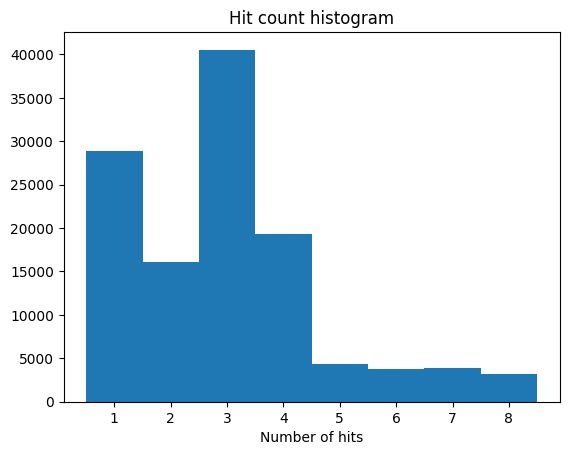

In [5]:
def plot_hit_count_histogram(dataset, title='Hit count histogram'):
    hit_count_histogram = [event_data.get_hit_count() for event_data in dataset.values()]

    plt.hist(hit_count_histogram, bins=range(1, 8 + 2), align='left')
    plt.title(title)
    plt.xlabel('Number of hits')
    
plot_hit_count_histogram(original_dataset)
plt.show()

# Utils

In [6]:
def plot_channel_data(data_dict, suptitle, xlabel, thresholds=None, bins=50, bin_width=None):
    plt.figure(figsize=(16, 6.5))
    plt.rc('font', size=8.5)
    for i, ((plane, channel), data) in enumerate(sorted(data_dict.items())):
        if thresholds is not None:
            t = thresholds[(plane, channel)]
            if bin_width is not None:
                bins = np.arange(t[0], t[1] + 0.9999 * bin_width, bin_width)

        plt.subplot(2, 4, i + 1)
        plt.hist(data, bins=bins)
        if thresholds is not None:
            plt.axvline(t[0], c='red')
            plt.axvline(t[1], c='red')
        plt.title(f'p {plane}, ch {channel}')
        plt.xlabel(xlabel)

    plt.suptitle(suptitle)
    plt.tight_layout()
    plt.show()

# Remove saturated and noisy events

In [7]:
channel_vmax_thresholds = {
    (0, 2):  (1.01, 1.02), # don't take anything
    (0, 11): (1.01, 1.02), # don't take anything
    (1, 2):  (0.36, 0.72),
    (1, 11): (0.36, 0.72),
    (2, 2):  (0.36, 0.72),
    (2, 11): (0.34, 0.72),
    (3, 2):  (0.34, 0.72),
    (3, 11): (0.32, 0.72)
}

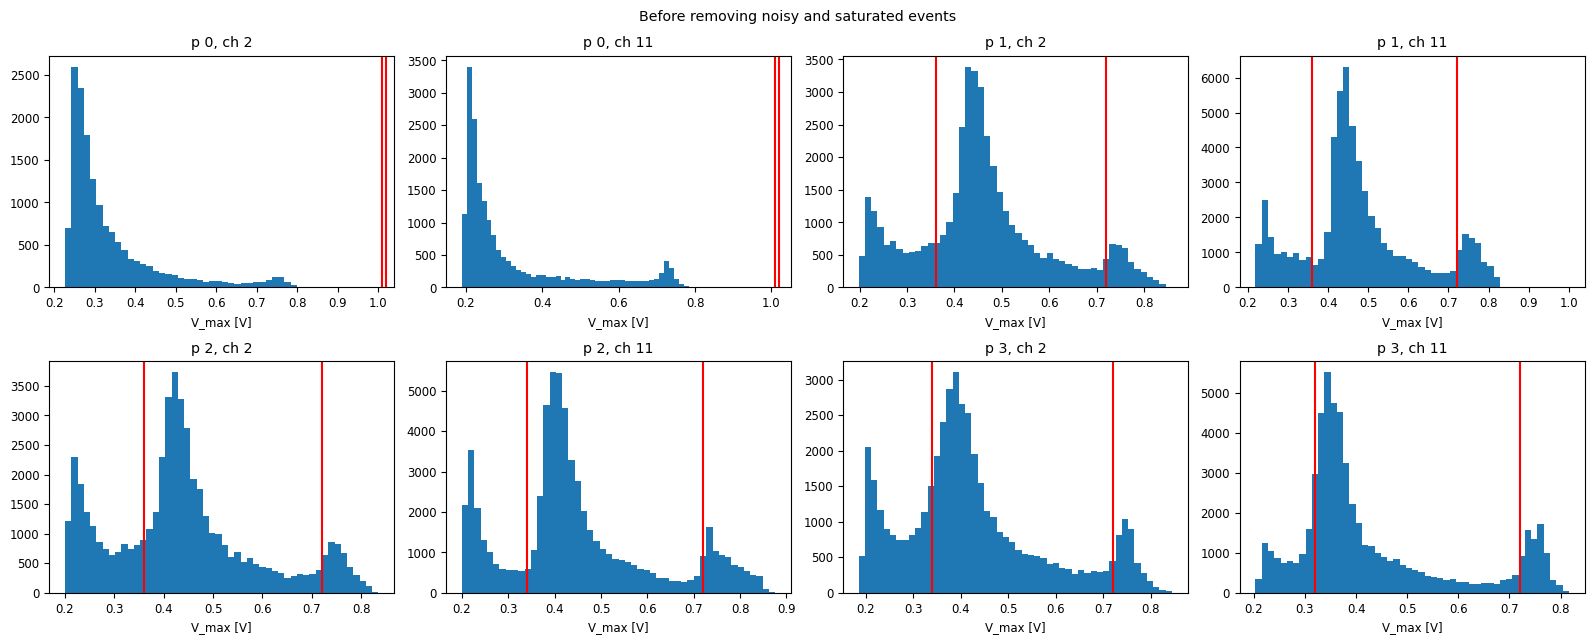

In [8]:
vmax_histograms = defaultdict(list)
for event, event_data in original_dataset.items():
    for plane, plane_data in event_data.planes.items():
        for channel, wav_data in plane_data.items():
            vmax_histograms[(plane, channel)].append(np.max(wav_data.series[1]))
            
plot_channel_data(vmax_histograms, 'Before removing noisy and saturated events', 'V_max [V]', channel_vmax_thresholds)

In [9]:
vmax_dataset = copy.deepcopy(original_dataset)

for event, event_data in vmax_dataset.items():
    for plane, plane_data in list(event_data.planes.items()):
        for channel, wav_data in list(plane_data.items()):
            thresholds = channel_vmax_thresholds[(plane, channel)]
            if not thresholds[0] <= np.max(wav_data.series[1]) <= thresholds[1]:
                event_data.remove_channel(plane, channel)

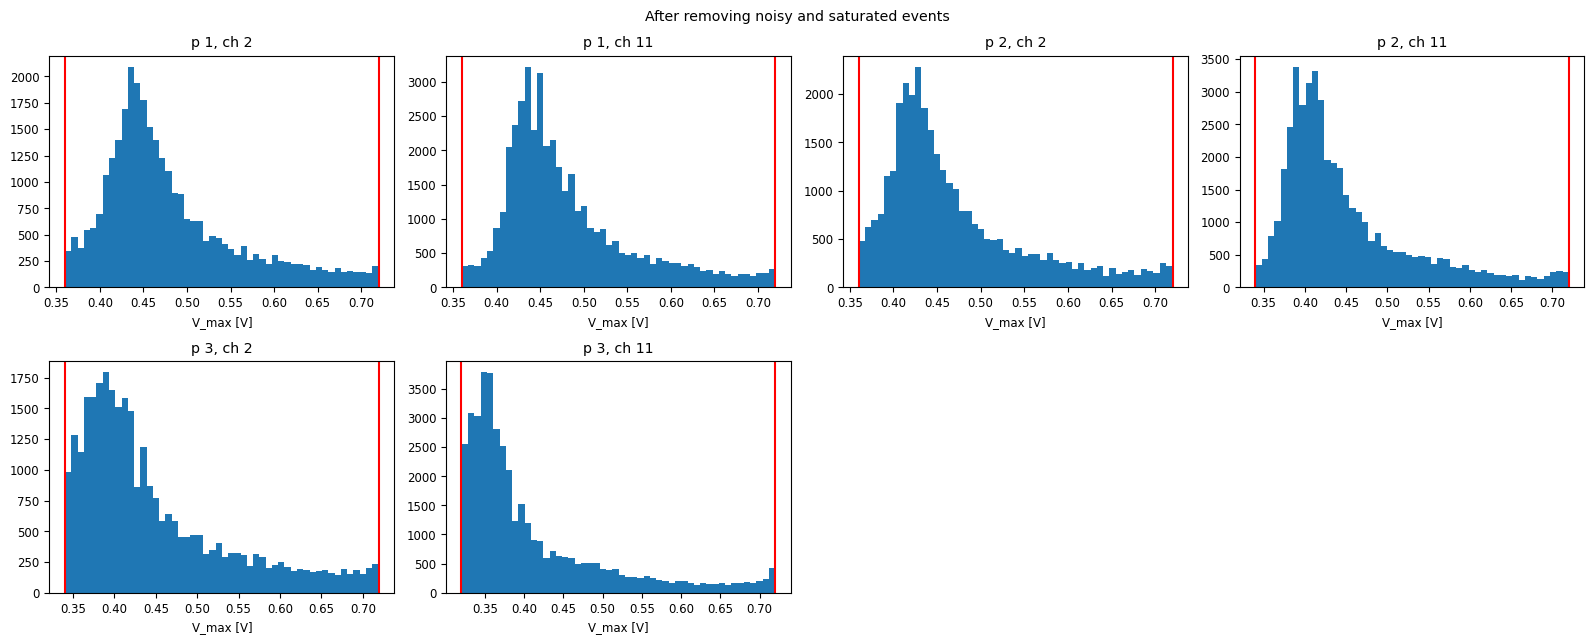

In [10]:
vmax_histograms = defaultdict(list)
for event, event_data in vmax_dataset.items():
    for plane, plane_data in event_data.planes.items():
        for channel, wav_data in plane_data.items():
            vmax_histograms[(plane, channel)].append(np.max(wav_data.series[1]))

plot_channel_data(vmax_histograms, 'After removing noisy and saturated events', 'V_max [V]', channel_vmax_thresholds)

# t0 histograms

In [11]:
# 8 1/3
channel_t0_thresholds = {
    (0, 2):  (-2, 2),
    (0, 11): (2, 2),
    (1, 2):  (-1.5, 2.5),
    (1, 11): (-2.5, 1.5),
    (2, 2):  (-0.5, 3.5),
    (2, 11): (-2, 2),
    (3, 2):  (-1.5, 2.5),
    (3, 11): (0, 4)
}

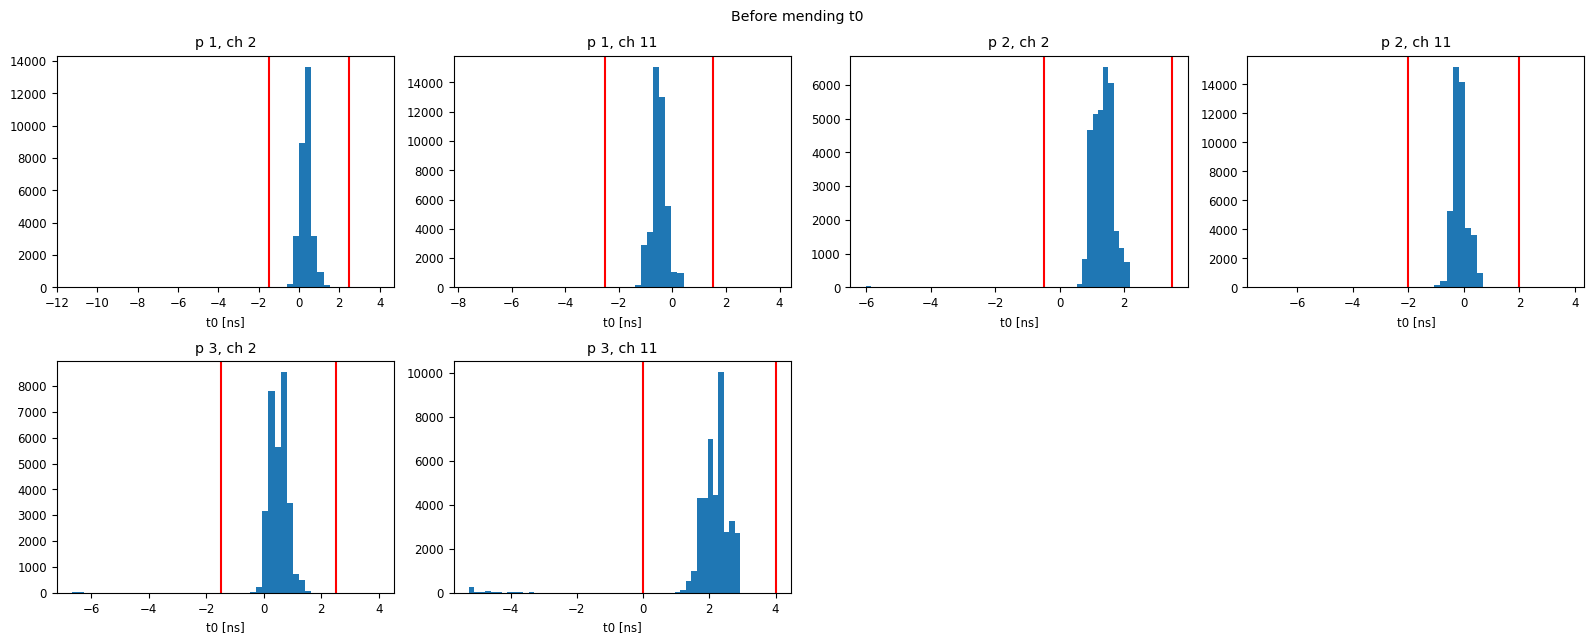

In [12]:
t0_dict = defaultdict(list)
for event_data in vmax_dataset.values():
    for plane, channel, wav_data in event_data.get_all_waveforms():
        t0_dict[(plane, channel)].append(wav_data.t0)

plot_channel_data(t0_dict, 'Before mending t0', 't0 [ns]', channel_t0_thresholds, bins=50)

In [13]:
t0_dataset = copy.deepcopy(vmax_dataset)

for event, event_data in t0_dataset.items():
    for plane, plane_data in list(event_data.planes.items()):
        for channel, wav_data in list(plane_data.items()):
            thresholds = channel_t0_thresholds[(plane, channel)]
            if not thresholds[0] <= wav_data.t0 <= thresholds[1]:
                event_data.remove_channel(plane, channel)

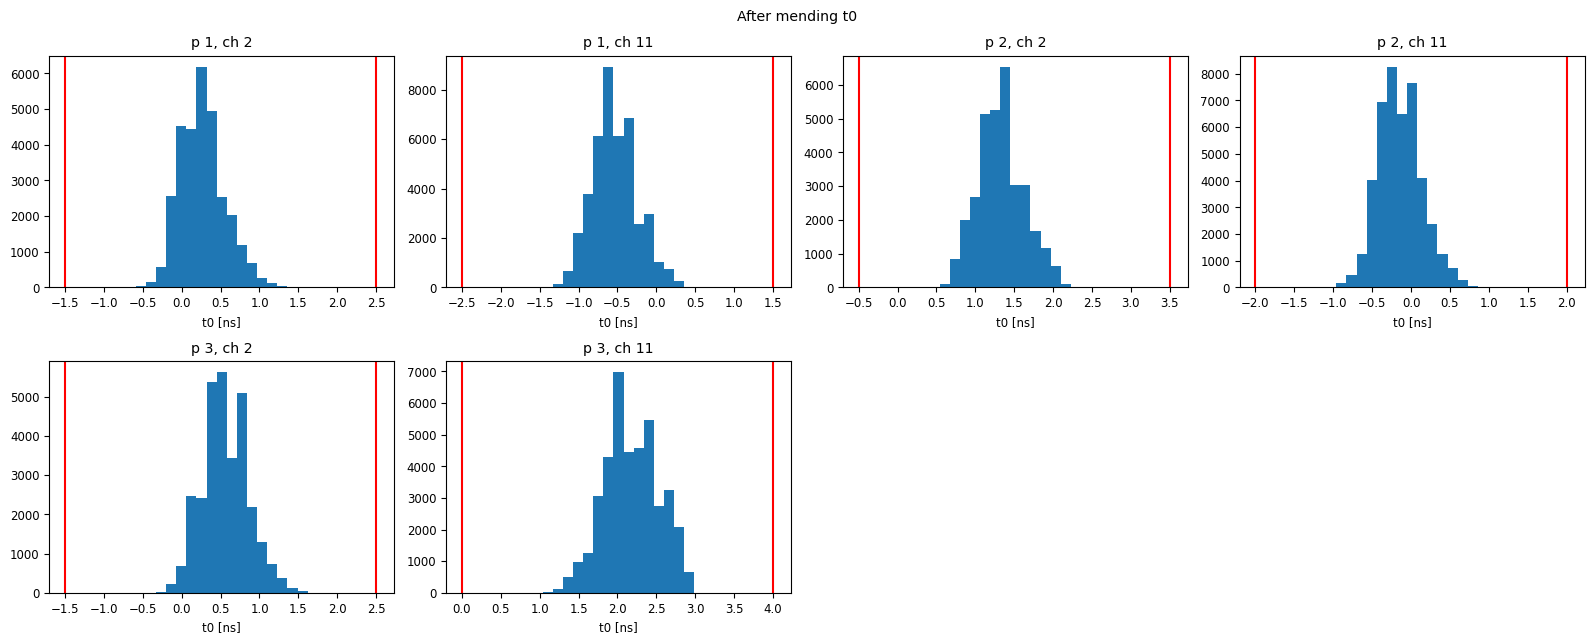

In [14]:
t0_dict = defaultdict(list)
for event_data in t0_dataset.values():
    for plane, channel, wav_data in event_data.get_all_waveforms():
        t0_dict[(plane, channel)].append(wav_data.t0)

plot_channel_data(t0_dict, 'After mending t0', 't0 [ns]', channel_t0_thresholds, bin_width=0.129955) # one bin around 1 / 7.695 ns = 0.129955 ns

# Find the optimal CFD threshold

In [15]:
def calculate_t_cfds(dataset: np.ndarray, cfd: CFD, copy_dataset=True):
    if copy_dataset:
        dataset = copy.deepcopy(dataset)
    for event, event_data in dataset.items():
        for plane, plane_data in list(event_data.planes.items()):
            for channel, wav_data in list(plane_data.items()):
                t = cfd.predict(wav_data.series[0], wav_data.series[1])
                if t is None: # Remove the events where CFD cannot be calculated
                    event_data.remove_channel(plane, channel)
                else:
                    wav_data.t_cfd = t
    return dataset
                    
def find_channel_cfd_averages(dataset: np.ndarray):
    cfd_histograms = defaultdict(list)
    for event, event_data in dataset.items():
        for plane, plane_data in event_data.planes.items():
            for channel, wav_data in plane_data.items():
                cfd_histograms[(plane, channel)].append(wav_data.t_cfd + wav_data.t0)

    channel_cfd_averages = {}
    for (plane, channel), cfds in sorted(cfd_histograms.items()):
        channel_cfd_averages[(plane, channel)] = np.average(cfds)
    
    return channel_cfd_averages, cfd_histograms

In [16]:
def compute_avg_threshold_std(threshold):
    print(f'Processing threshold={threshold:0.2f}...')
    cfd = CFD(n_baseline=CFD_N_BASELINE, threshold=threshold)
    dataset = calculate_t_cfds(t0_dataset, cfd, copy_dataset=False)
    channel_cfd_averages, _ = find_channel_cfd_averages(dataset)

    threshold_stds = []
    included_events = 0
    for event, event_data in list(dataset.items()):
        cfds = []
        for plane, plane_data in list(event_data.planes.items()):
            for channel, wav_data in list(plane_data.items()):
                cfds.append(wav_data.t_cfd + wav_data.t0 - channel_cfd_averages[(plane, channel)])

        if len(cfds) >= 2:
            threshold_stds.append(np.std(cfds))
            included_events += 1
    
    return threshold, np.average(threshold_stds), included_events

In [17]:
# # run and save results
# thresholds = np.arange(0.12, 0.3, 0.01)
# average_stds_results = Parallel(n_jobs=N_JOBS)(delayed(compute_avg_threshold_std)(threshold) for threshold in thresholds)

# with open(AVERAGE_STD_RESULTS_PATH, 'wb') as file:
#     pickle.dump(average_stds_results, file)

In [18]:
# load and process the results
with open(AVERAGE_STD_RESULTS_PATH, 'rb') as file:
    average_stds_results = pickle.load(file)
    
average_stds = dict([(a[0], a[1]) for a in average_stds_results])
included_events = dict([(a[0], a[2]) for a in average_stds_results])

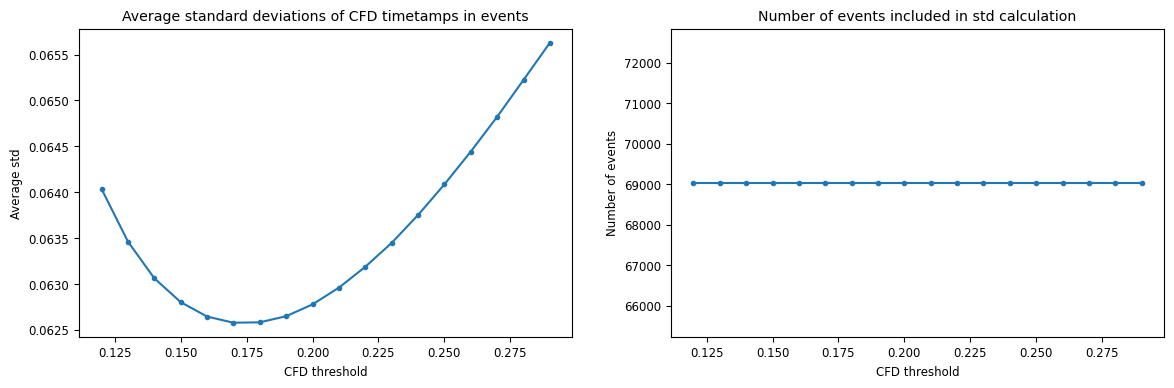

In [19]:
plt.figure(figsize=(14, 4))

plt.subplot(1, 2, 1)
plt.plot(average_stds.keys(), average_stds.values(), marker='.')
plt.title('Average standard deviations of CFD timetamps in events')
plt.xlabel('CFD threshold')
plt.ylabel('Average std')

plt.subplot(1, 2, 2)
plt.plot(included_events.keys(), included_events.values(), marker='.')
plt.title('Number of events included in std calculation')
plt.xlabel('CFD threshold')
plt.ylabel('Number of events')

plt.show()

In [20]:
optimal_cfd_threshold = list(average_stds.keys())[np.argmin(list(average_stds.values()))]
print(f'Optimal CFD threshold: {optimal_cfd_threshold:0.3f}')

Optimal CFD threshold: 0.170


# Calculate CFD timestamps and adjust t0

In [21]:
cfd_dataset = copy.deepcopy(t0_dataset)
cfd_avg_shift_applied = False

cfd = CFD(n_baseline=CFD_N_BASELINE, threshold=optimal_cfd_threshold)
for event, event_data in cfd_dataset.items():
    for plane, plane_data in list(event_data.planes.items()):
        for channel, wav_data in list(plane_data.items()):
            t = cfd.predict(wav_data.series[0], wav_data.series[1])
            if t is None: # Remove the events where CFD cannot be calculated
                event_data.remove_channel(plane, channel)
            else:
                wav_data.t_cfd = t

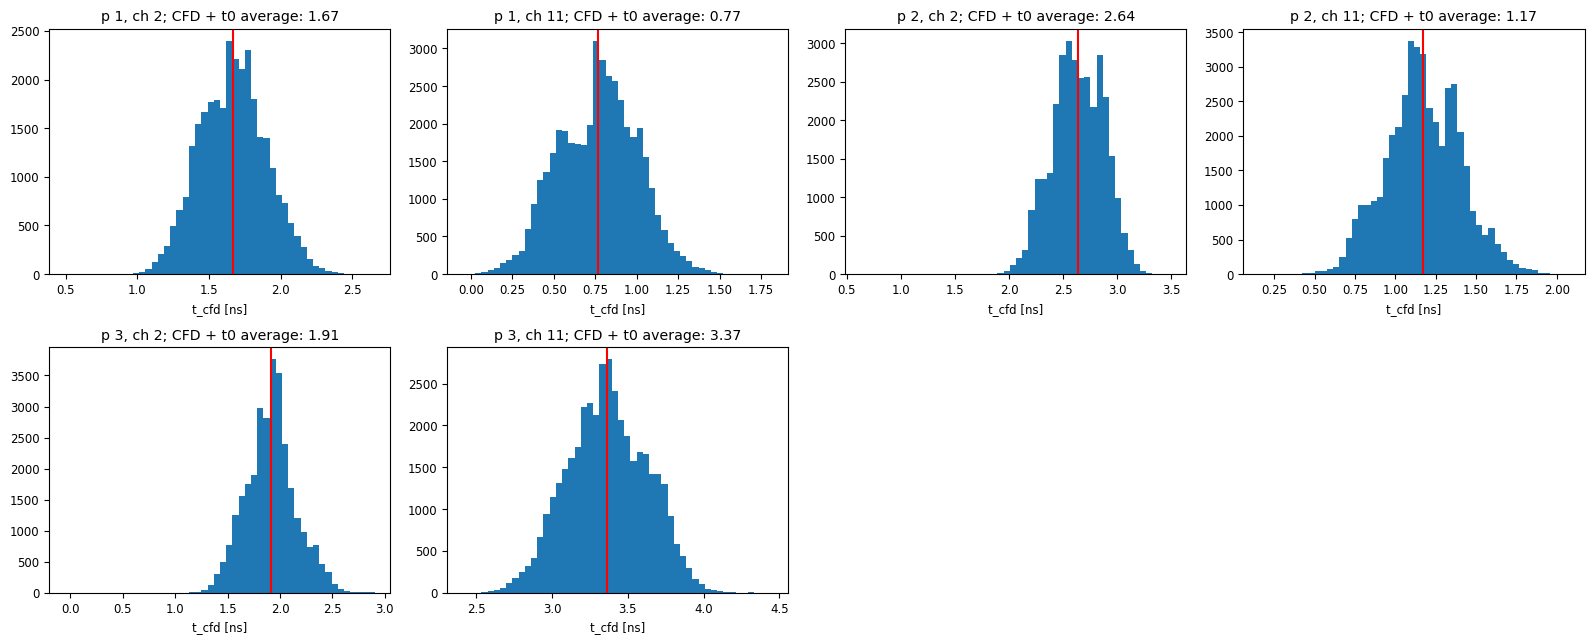

In [22]:
cfd_histograms = defaultdict(list)
for event, event_data in cfd_dataset.items():
    for plane, plane_data in event_data.planes.items():
        for channel, wav_data in plane_data.items():
            cfd_histograms[(plane, channel)].append(wav_data.t_cfd + wav_data.t0)
            
channel_cfd_averages = {}
for (plane, channel), cfds in sorted(cfd_histograms.items()):
    channel_cfd_averages[(plane, channel)] = np.average(cfds)

plt.figure(figsize=(16, 6.5))
plt.rc('font', size=8.5)
for i, ((plane, channel), cfds) in enumerate(sorted(cfd_histograms.items())):
    plt.subplot(2, 4, i + 1)
    plt.hist(cfds, bins=50)
    cfd_avg = channel_cfd_averages[(plane, channel)]
    plt.axvline(cfd_avg, c='red')
    plt.title(f'p {plane}, ch {channel}; CFD + t0 average: {cfd_avg:0.2f}')
    plt.xlabel('t_cfd [ns]')
    
plt.tight_layout()
plt.show()

In [23]:
if not cfd_avg_shift_applied:
    for event, event_data in cfd_dataset.items():
        for plane, plane_data in event_data.planes.items():
            for channel, wav_data in plane_data.items():
                wav_data.t0 -= channel_cfd_averages[(plane, channel)]
                pass

cfd_avg_shift_applied = True

# Take only interesting events

In [24]:
plane_count = 3
hit_count = 3

In [25]:
interesting_dataset = cfd_dataset = copy.deepcopy(cfd_dataset)

for event, event_data in list(interesting_dataset.items()):
    if event_data.get_plane_count() != plane_count or event_data.get_hit_count() != hit_count:
        del interesting_dataset[event]

# Calculate CFD event averages and clear the dataset

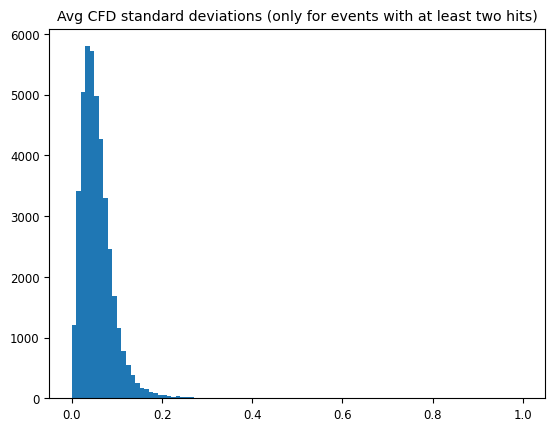

In [26]:
def compute_true_t_cfd(event_data: EventData, wav_data: WaveformData):
    # use only timestamps from other channels
    return ((event_data.get_hit_count() * event_data.t_cfd_average) - (wav_data.t_cfd + wav_data.t0)) / (event_data.get_hit_count() - 1) - wav_data.t0

stds = []
for event, event_data in list(interesting_dataset.items()):
    cfds = [wav_data.t_cfd + wav_data.t0 for _, _, wav_data in event_data.get_all_waveforms()]
    # cfds = [wav_data.t_cfd for _, _, wav_data in event_data.get_all_waveforms()]
    if not cfds: # Remove event if empty after the selection
        del interesting_dataset[event]
    else:
        event_data.t_cfd_average = np.average(cfds)
        for plane, plane_data in event_data.planes.items():
            for channel, wav_data in plane_data.items():
                wav_data.true_t_cfd = compute_true_t_cfd(event_data, wav_data)

        if len(cfds) >= 2:
            stds.append(np.std(cfds))
                        
plt.hist(stds, range=(0, 1), bins=100)
plt.title('Avg CFD standard deviations (only for events with at least two hits)')
plt.show()

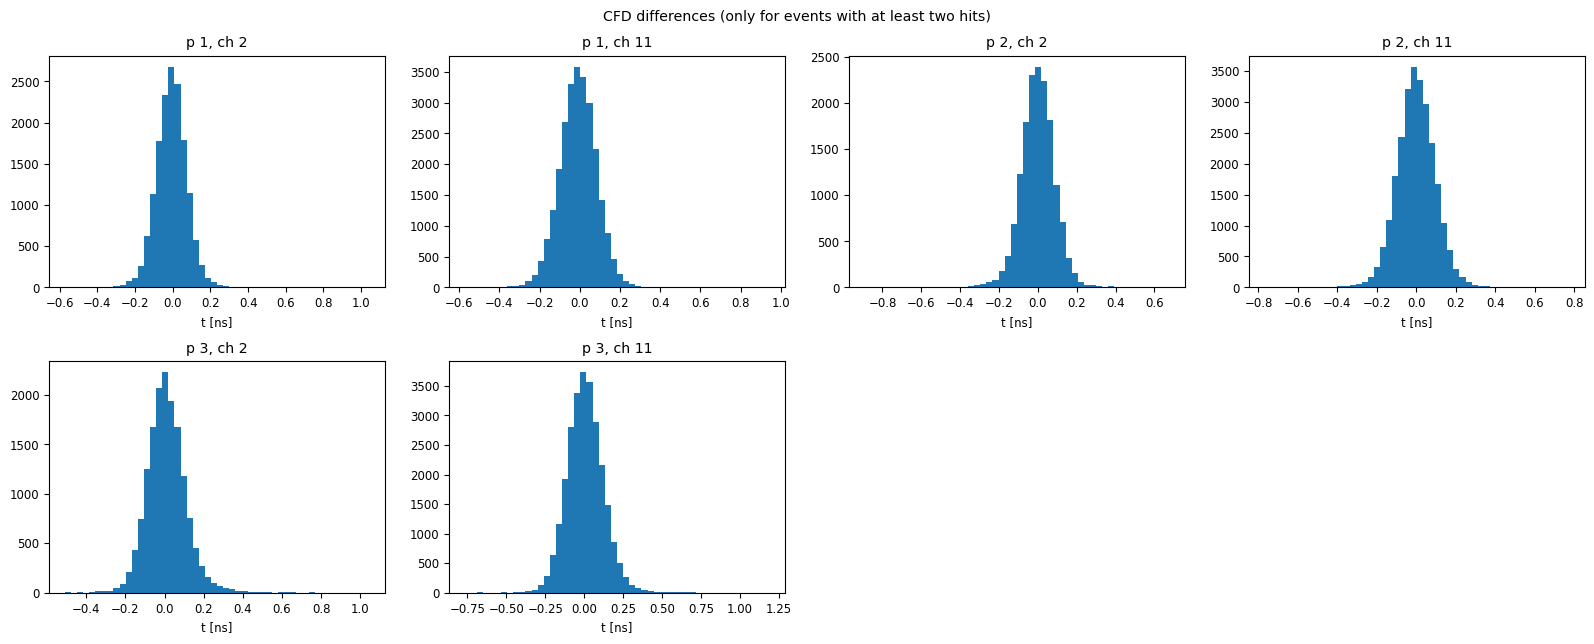

In [27]:
cfd_differences = defaultdict(list)
for event, event_data in interesting_dataset.items():
    if event_data.get_hit_count() >= 2:
        for plane, plane_data in event_data.planes.items():
            for channel, wav_data in plane_data.items():
                cfd_differences[(plane, channel)].append(wav_data.t_cfd - wav_data.true_t_cfd)

plot_channel_data(cfd_differences, 'CFD differences (only for events with at least two hits)', 't [ns]')

# Examples

In [28]:
dataset = interesting_dataset

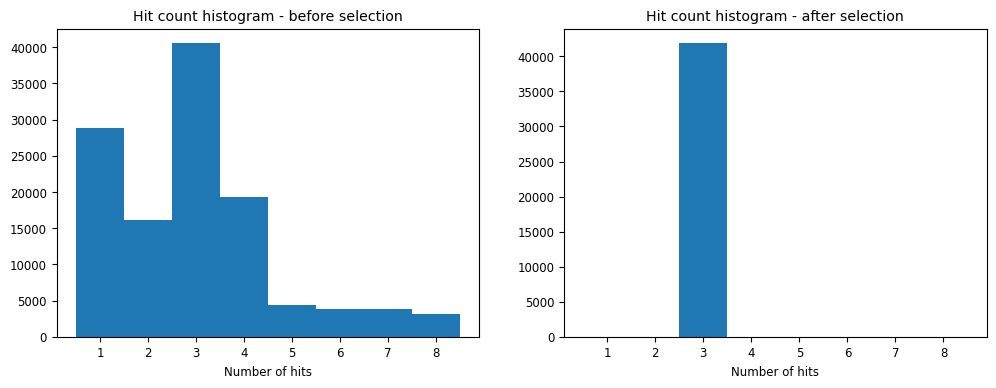

In [29]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plot_hit_count_histogram(original_dataset, title='Hit count histogram - before selection')

plt.subplot(1, 2, 2)
plot_hit_count_histogram(dataset, title='Hit count histogram - after selection')

plt.show()

In [30]:
events_to_view = []
for event, event_data in dataset.items():
    if event_data.get_plane_count() == 3 and event_data.get_hit_count() == 3:
        events_to_view.append(event)
    if len(events_to_view) == 8:
        break
        
events_to_view

[3375, 9900, 17550, 19792, 24253, 25595, 26550, 27904]

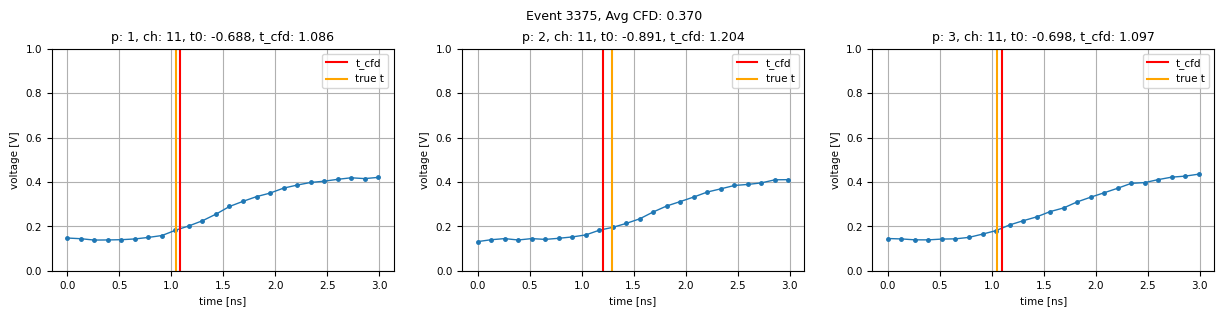

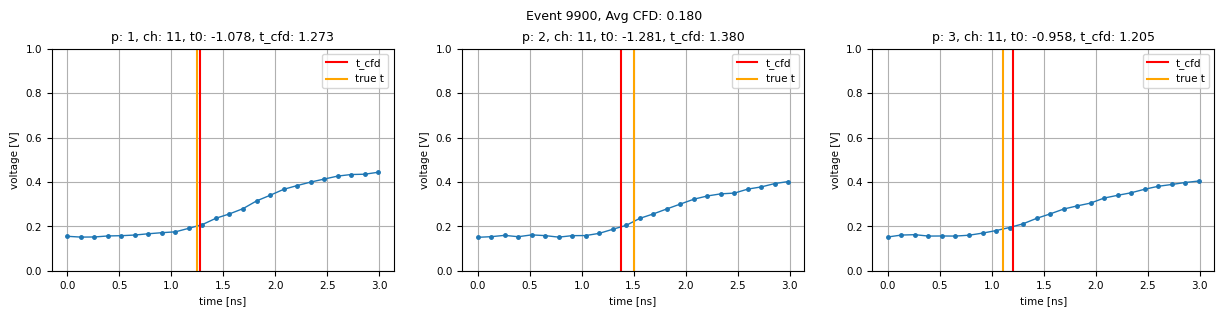

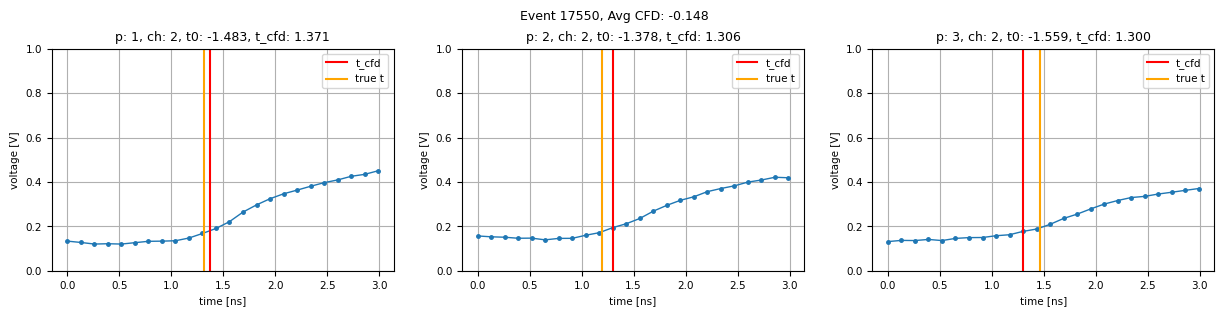

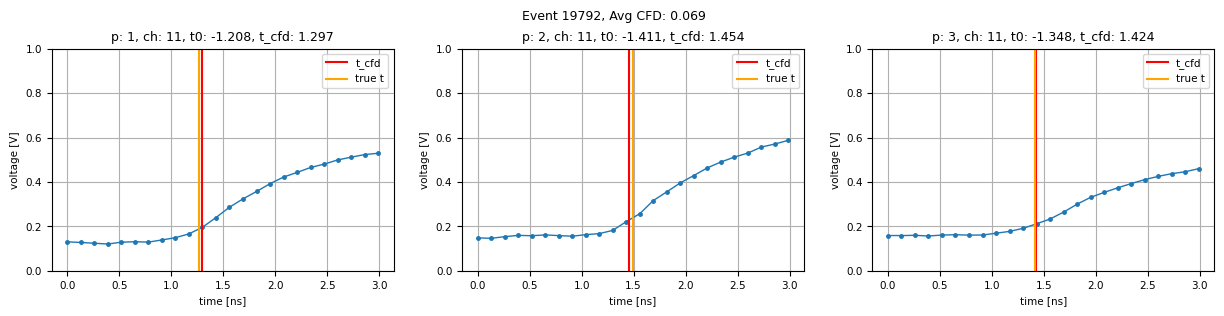

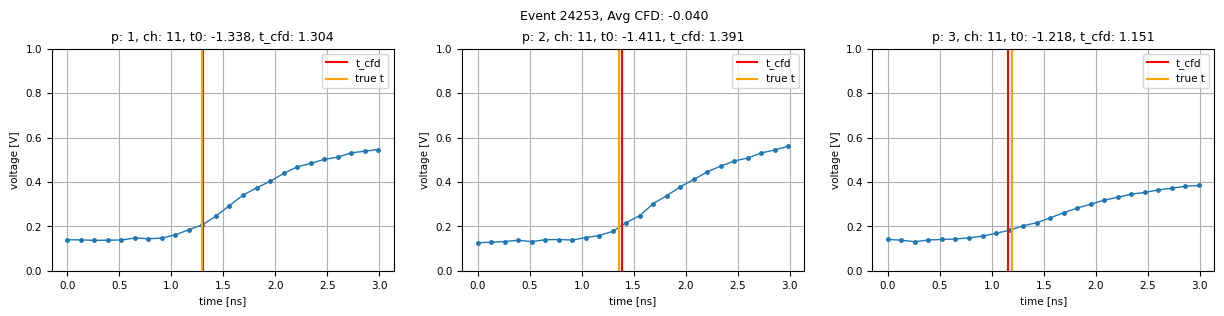

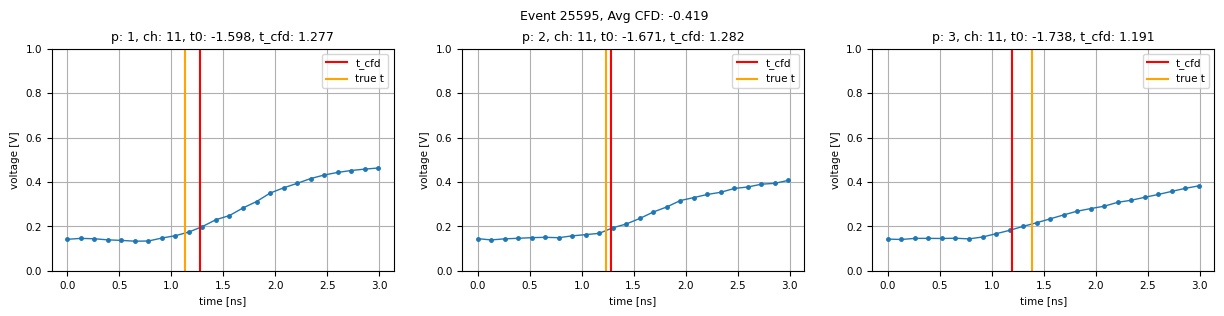

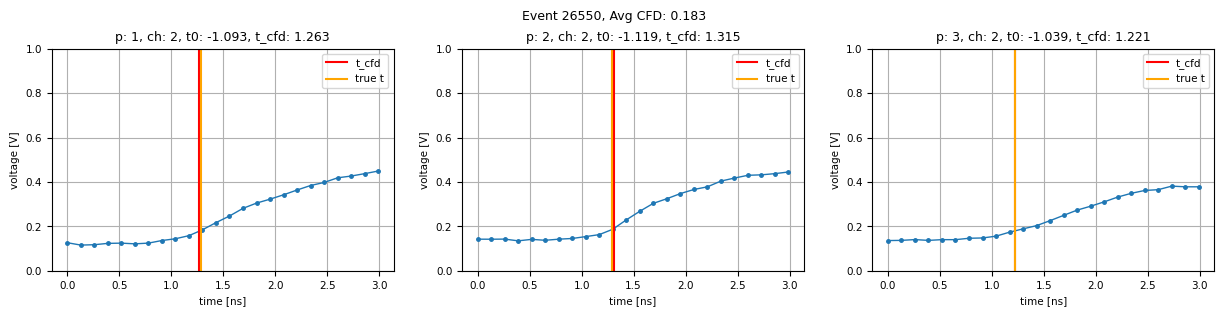

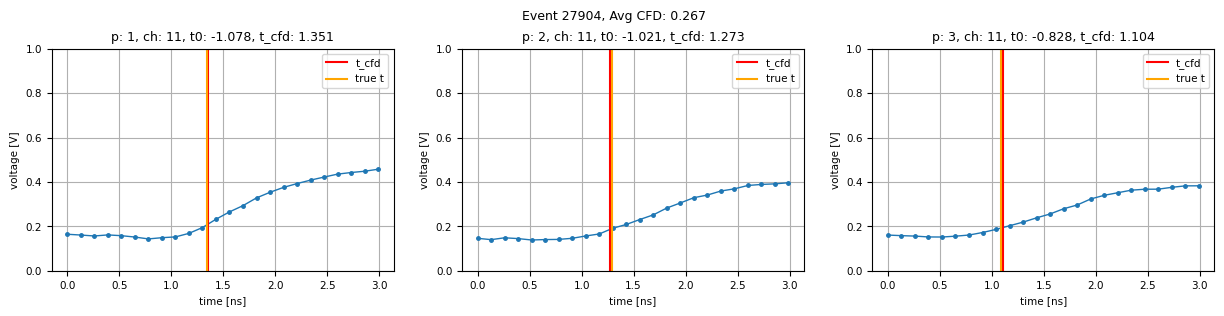

In [31]:
for event in events_to_view:
    plt.figure(figsize=(15, 3))
    plt.rc('font', size=7.5)
    
    for i, (plane, channel, wav_data) in enumerate(dataset[event].get_all_waveforms()):
        plt.subplot(1, 3, i + 1)
        plt.plot(wav_data.series[0], wav_data.series[1], marker='.', linewidth=1, markersize=5)
        if wav_data.t_cfd is not None:
            plt.axvline(wav_data.t_cfd, c='red', label='t_cfd')
        plt.axvline(wav_data.true_t_cfd, c='orange', label='true t')
        plt.ylim(0, 1)
        t_cfd_str = f'{wav_data.t_cfd:0.3f}' if wav_data.t_cfd is not None else 'None'
        plt.title(f'p: {plane}, ch: {channel}, t0: {wav_data.t0:0.3f}, t_cfd: {t_cfd_str}')
        plt.xlabel('time [ns]')
        plt.ylabel('voltage [V]')
        plt.legend()
        plt.grid()
        # print(f'({plane}, {channel}): {wav_data.t_cfd + wav_data.t0:0.2f}')
    
    # plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.suptitle(f'Event {event}, Avg CFD: {dataset[event].t_cfd_average:0.3f}')
    
    plt.show()

In [32]:
for event in events_to_view[:2]:
    print('Event:', event)
    pprint(dataset[event].get_metadata_dict())

Event: 3375
{'plane 1': {'channel 11': "{'t0': -0.6880527780005106, 't_cfd': "
                           '1.0857237660078467}'},
 'plane 2': {'channel 11': "{'t0': -0.8910828241968749, 't_cfd': "
                           '1.2039163132496218}'},
 'plane 3': {'channel 11': "{'t0': -0.6984474437957586, 't_cfd': "
                           '1.0968404414711237}'}}
Event: 9900
{'plane 1': {'channel 11': "{'t0': -1.077915792221702, 't_cfd': "
                           '1.2726141430637843}'},
 'plane 2': {'channel 11': "{'t0': -1.2809467920923827, 't_cfd': "
                           '1.3796014340931286}'},
 'plane 3': {'channel 11': "{'t0': -0.9583565967803778, 't_cfd': "
                           '1.2050687304945447}'}}


# Produce and save the dataset

In [33]:
final_dataset = defaultdict(lambda: [[], []])

for event, event_data in dataset.items():
    for plane, plane_data in list(event_data.planes.items()):
        for channel, wav_data in list(plane_data.items()):
            final_dataset[(plane, channel)][0].append(wav_data.series[1])                     # series (x)
            final_dataset[(plane, channel)][1].append(event_data.t_cfd_average - wav_data.t0) # ground truth t_cfd (y)
            
final_dataset = dict(sorted(final_dataset.items())) # sort to have expected plane/channel order

for plane, channel in final_dataset:
    final_dataset[(plane, channel)][0] = np.array(final_dataset[(plane, channel)][0])
    final_dataset[(plane, channel)][1] = np.array(final_dataset[(plane, channel)][1])

In [34]:
# store the dataset
with open(DATASET_PATH, 'wb') as file:
    pickle.dump(final_dataset, file)

In [35]:
for plane, channel in sorted(final_dataset.keys()):
    data = final_dataset[(plane, channel)]
    print(f'p {plane}, ch {channel:>2}; {len(data[1])} events')

p 1, ch  2; 15587 events
p 1, ch 11; 26269 events
p 2, ch  2; 15669 events
p 2, ch 11; 26187 events
p 3, ch  2; 15580 events
p 3, ch 11; 26276 events
